<a href="https://colab.research.google.com/github/adelsuh/cs224_final_project/blob/main/graph_structure_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS224W Final Project: Tutorial on the Augmentation of Graphs in PyG

### Jerry Chan, Jihee Suh, John So

### Notebook setup: install PyG + torch

In [1]:
import torch
torch_version = str(torch.__version__)
if "2.4.0" not in torch_version:
  !pip install torch==2.4.0 -q
print(torch_version)

2.4.0+cu121


In [2]:
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip install torch-scatter -f $scatter_src -q
!pip install torch-sparse -f $sparse_src -q
!pip install torch-geometric -q
!pip install ogb -q

In [3]:
import os
import random
import numpy as np
import torch

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

using device: cpu


### Setting up the dataset and tasks

The below code sets up some hyperparameters which will be used in dataloading and training.


In [4]:
# Model settings
hidden_dim = 128 #@param {type: "integer"}
num_layers = 4 #@param {type: "integer"}
# Training settings
learning_rate = 0.0001 #@param {type: "number"}
num_epochs = 10 #@param {type: "integer"}

# Dataloader settings
batch_size = 32 #@param {type: "integer"}
fan_out = 10 #@param {type: "integer", hint: "Used in neighborhood sampling to sample a subgraph"}
dataloader_num_workers = 2 #@param {type: "integer"}

print(f"""
Running training with the following configuration:
   hidden_dim: {hidden_dim}
   num_layers: {num_layers}
   learning_rate: {learning_rate}
   num_epochs: {num_epochs}
   batch_size: {batch_size}
""")


Running training with the following configuration:
   hidden_dim: 128
   num_layers: 4
   learning_rate: 0.0001
   num_epochs: 10
   batch_size: 32



### About the task: etc. etc.

Some generic description about obgn.

Run the below block to create the dataset. If this is your first time loading the dataset, it will additionally prompt you to download files.

**Note**: this block loads the dataset into RAM each time it is called! So calling this block multiple times will likely consume all of the notebook's RAM. Take caution.

In [5]:
from ogb.nodeproppred import PygNodePropPredDataset
from ogb.graphproppred import PygGraphPropPredDataset
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='./arxiv/')

/usr/local/lib/python3.10/dist-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_

In [6]:
split_idx = dataset.get_idx_split()
# sample test set to speed up
split_idx['test'] = split_idx['test']
split_idx['valid'] = split_idx['valid']

print(f"""
Summary of the OBGN Arxiv dataset:
  Number of graphs: {len(dataset)}
  Number of features: {dataset.num_features}
  Number of classes: {dataset.num_classes}
  Length of each split:
    Training: {len(split_idx['train'])}
    Validation: {len(split_idx['valid'])}
    Test: {len(split_idx['test'])}
""")


Summary of the OBGN Arxiv dataset:
  Number of graphs: 1
  Number of features: 128
  Number of classes: 40
  Length of each split:
    Training: 90941
    Validation: 29799
    Test: 48603



Now, let's create some dataloaders!

todo: write something about neighbor loader. why do we need this?

In [7]:
from torch_geometric.loader import NeighborLoader

data = dataset[0]
train_loader = NeighborLoader(
    data,
    input_nodes=split_idx['train'],
    num_neighbors=[fan_out] * num_layers,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=dataloader_num_workers
)
val_loader = NeighborLoader(
    data,
    input_nodes=split_idx['valid'],
    num_neighbors=[fan_out] * num_layers,
    batch_size=batch_size,
    shuffle=True,
    num_workers=dataloader_num_workers,
)
test_loader = NeighborLoader(
    data,
    input_nodes=split_idx['test'],
    num_neighbors=[fan_out] * num_layers,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [8]:
print(f"Example batch:")
train_batch = next(iter(train_loader))
print(train_batch)

Example batch:
Data(num_nodes=1512, edge_index=[2, 2194], x=[1512, 128], node_year=[1512, 1], y=[1512, 1], n_id=[1512], e_id=[2194], input_id=[32], batch_size=32)


### Training and Evaluation Utilities

In [9]:
from torch_geometric.nn.models import GraphSAGE

input_dim = dataset.num_features

def get_model():
    class GraphSAGENodeClassification(torch.nn.Module):
        def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
            super(GraphSAGENodeClassification, self).__init__()
            self.graph_sage = GraphSAGE(in_channels = input_dim, hidden_channels = hidden_dim, num_layers=num_layers)
            self.cls_head = torch.nn.Sequential(
                torch.nn.Dropout(0.1),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, num_classes),
            )
            self.loss_fn = torch.nn.CrossEntropyLoss()

        def forward(self, x, edge_index):
            h = self.graph_sage(x, edge_index)
            return self.cls_head(h)

    model = GraphSAGENodeClassification(input_dim, hidden_dim, num_layers, dataset.num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    return model, optimizer

Next, we define a simple training loop and evaluation function:


In [10]:
from tqdm import tqdm

# training process
def train_one_epoch(model,
                    dataloader,
                    optimizer,
                    transform=None,
                    filter_output_fn=None):
    """
    Run one epoch of training on the model on the given dataset.

    Args:
        model (torch.nn.Module): The model to evaluate.
        dataloader (torch.utils.data.DataLoader): The dataloader for the dataset.
        transform: if specified and apply_transform is True, a transformation to apply to each batch
        filter_output_fn: if specified and apply_transform is True, a transformation to apply to the output of each batch.
    """
    model.train()

    # define stats
    total_loss = 0
    total_correct = 0
    num_examples = 0

    for batch in tqdm(dataloader):

        # transform batch if needed
        batch_size = batch.batch_size
        batch = batch.to(device)
        if transform is not None:
          batch = transform(batch)
        # forward pass
        optimizer.zero_grad()
        logits = model(batch.x, batch.edge_index)
        if filter_output_fn is not None:
          logits = filter_output_fn(logits, batch)

        # backward pass
        num_labels = logits.shape[0]
        labels = batch.y.squeeze(-1)

        loss = model.loss_fn(logits, labels)
        loss.backward()
        optimizer.step()


        # log stats
        total_loss += loss.item() * num_labels
        total_correct += logits.argmax(dim=-1).eq(labels).sum().item()
        num_examples += num_labels

    loss = total_loss / num_examples
    acc = total_correct / num_examples
    return loss, acc

# test process
@torch.no_grad()
def test(model,
         dataloader,
         transform=None,
         filter_output_fn=None,
         apply_transform=True):
    """
    Calculate metrics for the model on the given dataset.

    Args:
        model (torch.nn.Module): The model to evaluate.
        dataloader (torch.utils.data.DataLoader): The dataloader for the dataset.
        apply_transform: whether to use the arguments transform and filter_output_fn.
        transform: if specified and apply_transform is True, a transformation to apply to each batch
        filter_output_fn: if specified and apply_transform is True, a transformation to apply to the output of each batch.
    """
    model.eval()

    # define states
    total_loss = 0
    total_correct = 0
    num_examples = 0

    for batch in tqdm(dataloader):
        # transform batch if needed
        batch_size = batch.batch_size
        batch = batch.to(device)
        if apply_transform and (transform is not None):
          batch = transform(batch)

        # forward pass
        logits = model(batch.x, batch.edge_index)
        if apply_transform and (filter_output_fn is not None):
          logits = filter_output_fn(logits, batch)

        # compute loss
        num_labels = logits.shape[0]
        labels = batch.y.squeeze(-1)
        loss = model.loss_fn(logits, labels)
        # log stats
        total_loss += loss.item() * num_labels
        total_correct += logits.argmax(dim=-1).eq(labels).sum().item()
        num_examples += num_labels

    loss = total_loss / num_examples
    acc = total_correct / num_examples
    return loss, acc

To train and evaluate out model, call the below function!

In [11]:
def train(model,
          optimizer,
          num_epochs,
          transform=None,
          filter_output_fn=None,
          apply_transform_at_test=True):
    all_train_acc, all_val_acc, all_test_acc = [], [], []
    best_val_ind, best_val_acc = 0, 0
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1:02d}')

        # training
        train_loss, train_acc = train_one_epoch(model,
                                                train_loader,
                                                optimizer,
                                                transform,
                                                filter_output_fn)
        val_loss, val_acc = test(model,
                                 val_loader,
                                 transform,
                                 filter_output_fn=filter_output_fn,
                                 apply_transform=apply_transform_at_test)
        test_loss, test_acc = test(model,
                                   test_loader,
                                   transform,
                                   filter_output_fn=filter_output_fn,
                                   apply_transform=apply_transform_at_test)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_ind = epoch

        print(f'Train {train_loss:.4f} ({100.0 * train_acc:.2f}%) | Val {val_loss:.4f} ({100.0 * val_acc:.2f}%) | Test {test_loss:.4f} ({100.0 * test_acc:.2f}%)')

        all_train_acc.append(train_acc)
        all_val_acc.append(val_acc)
        all_test_acc.append(test_acc)

    return {
        'all_train_acc': np.array(all_train_acc),
        'all_val_acc': np.array(all_val_acc),
        'all_test_acc': np.array(all_test_acc),
        'best_val_ind': best_val_ind,
        'model': model
    }

To illustrate some example usage, let's run a baseline. This trains a GraphSAGE network with no graph structure augmentations.

In [ ]:
model, optimizer = get_model()
results = train(model, optimizer, num_epochs=num_epochs)

best_bl_train_acc = results['all_train_acc'][results['best_val_ind']]
best_bl_val_acc = results['all_val_acc'][results['best_val_ind']]
best_bl_test_acc = results['all_test_acc'][results['best_val_ind']]

Epoch: 01


100%|██████████| 1519/1519 [00:07<00:00, 191.94it/s]


Train 1.8865 (47.50%) | Val 1.4823 (59.03%) | Test 1.5508 (57.39%)
Epoch: 02


100%|██████████| 1519/1519 [00:06<00:00, 221.66it/s]


Train 1.4882 (57.95%) | Val 1.3542 (61.75%) | Test 1.4164 (60.29%)
Epoch: 03


 76%|███████▌  | 708/932 [00:12<00:04, 44.81it/s]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Optional

# Set a clean, modern aesthetic
plt.style.use('seaborn-v0_8-pastel')
sns.set_palette("deep")

def plot(x: Optional[np.ndarray] = None,
         y: Dict[str, np.ndarray] = dict(),
         xlabel: str = "",
         ylabel: str = "accuracy"):

  plt.figure(figsize=(6, 4), dpi=300)

  for key, value in y.items():
    if x is not None:
      plt.plot(x, value, label=key)
    else:
      plt.plot(value, label=key)

  plt.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)
  plt.title('training accuracy', fontsize=16)
  if x is not None:
    plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  plt.legend(frameon=True, fancybox=True, framealpha=0.7)
  plt.tight_layout()
  plt.gca().set_facecolor('none')
  plt.gcf().patch.set_alpha(0.0)

  plt.show()

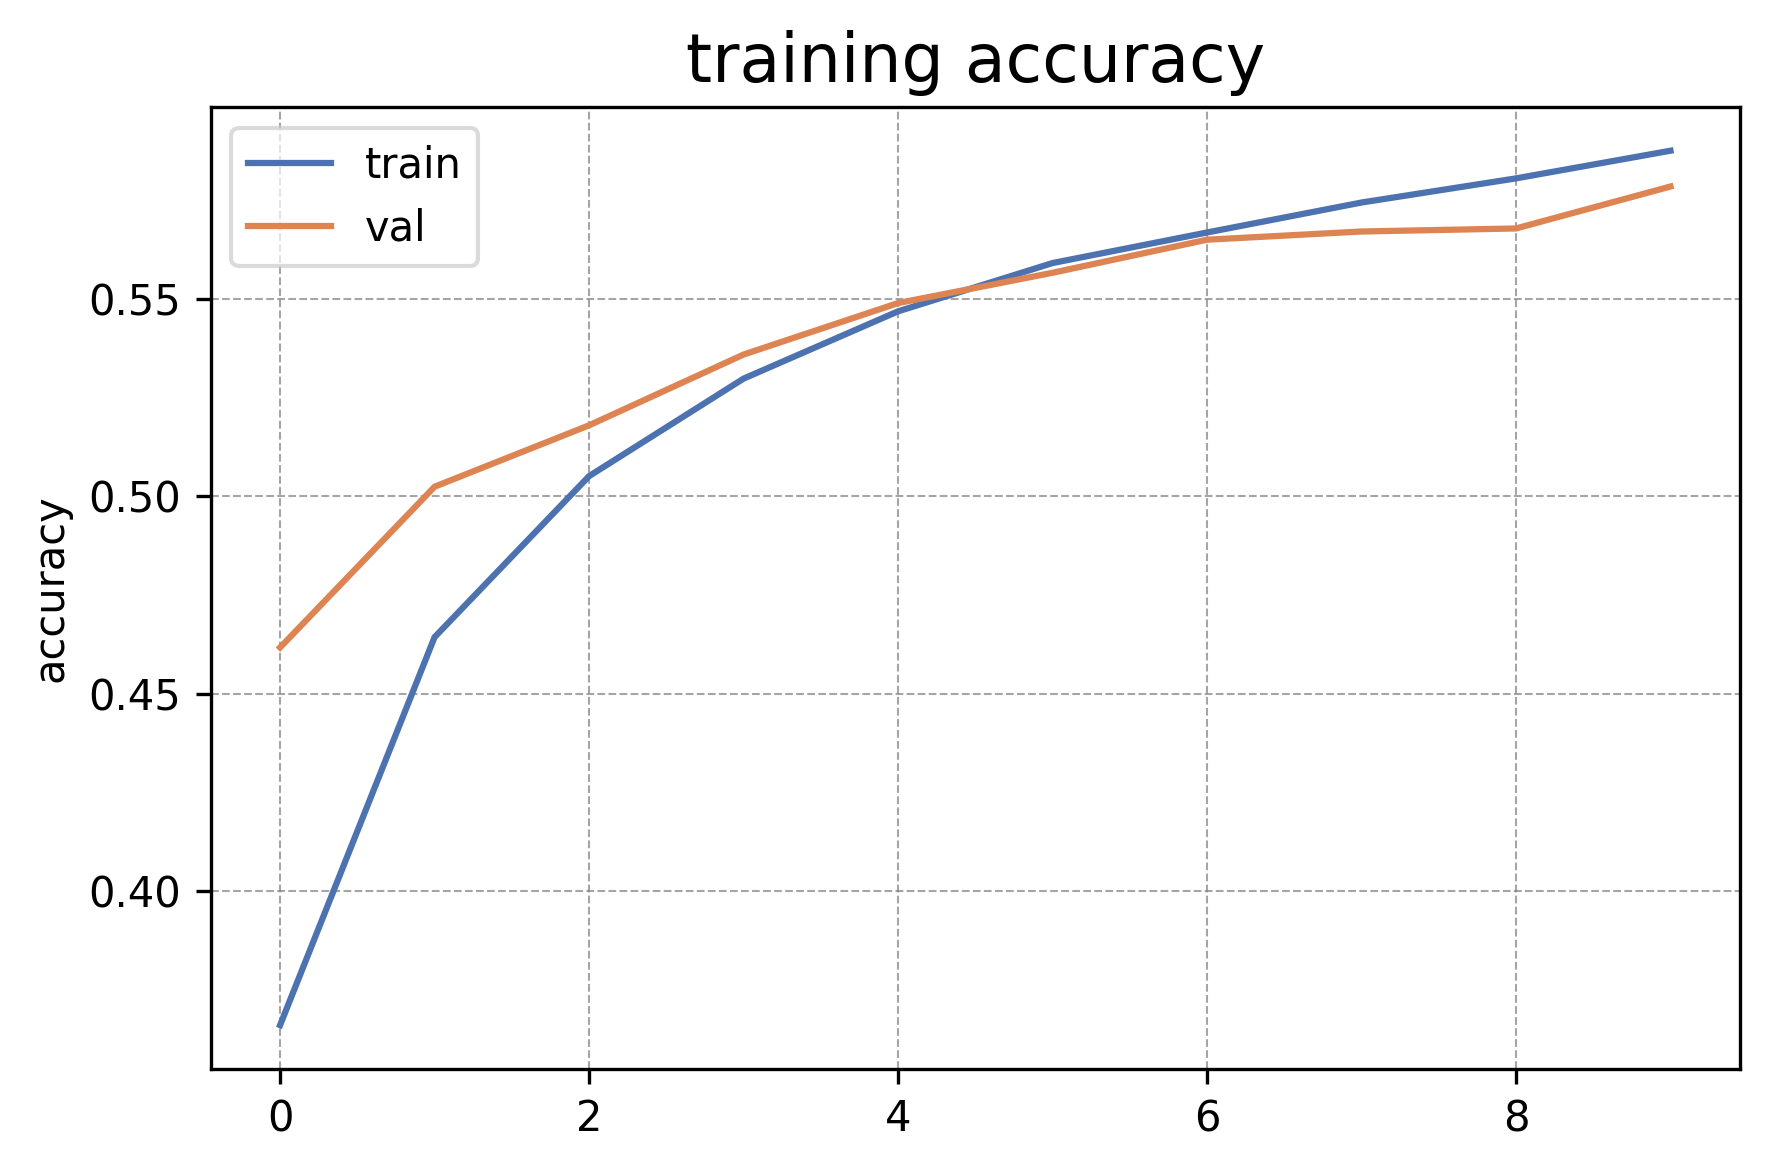

In [32]:
to_plot = {
    "train": results['all_train_acc'],
    "val": results['all_val_acc'],
}

plot(y=to_plot, xlabel="epoch")

## Graph Structure Augmentation

Modifying the **struture** of the graph is also a powerful way to improve the performance of GNNs. The performance of GNNs is very much related to the structure of the graph.

To better motivate graph structure augmentations, let’s first revisit the core idea of GNNs: message passing. At each layer, nodes aggregate information from their neighbors, gradually building a representation that reflects their local neighborhood structure. In theory, deeper networks should be able to capture broader relationships in the graph, integrating information from distant nodes.

- **Over-smoothing**:    Recall that a GNN with $k$ layers aggregates information from each node's $k$-hop neighborhood. Thus, as the network deepens, node representations increasingly mix, and after many layers, nodes tend to converge to very similar representations. This “blending” means that the network struggles to distinguish between nodes, especially in large, densely connected graphs. In extreme cases, the output becomes almost uniform across all nodes, rendering the GNN ineffective for tasks like classification or clustering.

- **Global relationships**:    While increasing the receptive field of each node by stacking more GNN layers might seem like a solution, it exacerbates the over-smoothing problem noted above, highlighting the trade-offs between depth and effective information propagation.

Graph structure augmentations tackle these challenges head-on by altering the graph’s connectivity, introducing extra nodes and/or edges. to improve the flow of information across the graph, mitigate over-smoothing, and enable GNNs to better capture both local and global patterns.

### Half Hop

Half-Hop (introduced in [Azabou 2023](https://arxiv.org/abs/2308.09198)) enhances message passing in neural networks by inserting intermediate "slow nodes" between connected nodes in a graph. This approach mitigates over-smoothing and improves performance, especially in scenarios where neighboring nodes have different labels. The PyG documentation can be found [here](https://pytorch-geometric.readthedocs.io/en/stable/generated/torch_geometric.transforms.HalfHop.html).

In [85]:
import pandas as pd

from torch_geometric.transforms import HalfHop
# blend features from src and dest equally (alpha=0.5).
# add a virtual node to all edges (p=1)

def hh_filter(outputs, batch):
  # note that the labels (i.e. batch.y) do not need to be masked.
  # dummy labels are not added
  return outputs[~batch.slow_node_mask]

probs = [0.1, 0.5, 1.0]
best_hh_train_acc, best_hh_val_acc, best_hh_test_acc = [], [], []
for hh_prob in probs:
    hh_transform = HalfHop(alpha=0.5, p=hh_prob)
    model, optimizer = get_model()
    print(f"Training with half-hop probability of {hh_prob}\n")
    result = train(model,
                   optimizer,
                   num_epochs=num_epochs,
                   transform=hh_transform,
                   filter_output_fn=hh_filter,
                   apply_transform_at_test=True)

    best_ind = result['best_val_ind']
    best_hh_train_acc.append(result['all_train_acc'][best_ind])
    best_hh_val_acc.append(result['all_val_acc'][best_ind])
    best_hh_test_acc.append(result['all_test_acc'][best_ind])

Training with half-hop probability of 0.1

Epoch: 01


  0%|          | 0/2842 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  1%|          | 27/2842 [00:03<06:18,  7.44it/s]


KeyboardInterrupt: 

In [ ]:
to_plot = {
    "train": best_train_acc,
    "val": best_val_acc,
    "test": best_test_acc
}

plot(x=probs, y=to_plot, xlabel="half-hop probability")

<Axes: xlabel='masking_prob', ylabel='test_acc'>

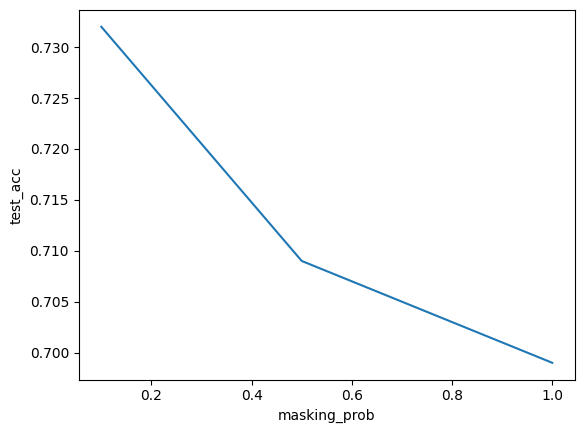

In [ ]:
import seaborn as sns

if not os.path.exists("out"):
    os.makedirs("out")
df = pd.DataFrame(rows)
df.to_csv("out/masking_prob_results.csv")
df

df.to_csv("out/masking_prob_results.csv")
sns.lineplot(data=df, x="masking_prob", y="test_acc")

### Virtual Node

VirtualNode (introduced in [Gilmer 2017](https://arxiv.org/abs/1704.01212)) appends a virtual node to the given homogeneous graph that is connected to all other nodes. The virtual node serves as a global scratch space that each node both reads from and writes to in every step of message passing. This allows information to travel long distances during the propagation phase.

In [82]:
import pandas as pd

from torch_geometric.transforms import VirtualNode

def vn_filter(outputs, batch):
  # virtual node adds a dummy label (0), and a dummy node (0)
  return outputs

vn_transform = VirtualNode()
model, optimizer = get_model()
print(f"Training with virtual node\n")
result = train(model,
                optimizer,
                num_epochs=num_epochs,
                transform=vn_transform,
                filter_output_fn=vn_filter,
                apply_transform_at_test=True)

best_ind = result['best_val_ind']
best_vn_train_acc = result['all_train_acc'][best_ind]
best_vn_val_acc = result['all_val_acc'][best_ind]
best_vn_test_acc = result['all_test_acc'][best_ind]

Training with virtual node

Epoch: 01


  0%|          | 0/2842 [00:00<?, ?it/s]

before transform: torch.Size([1906, 128]), torch.Size([1906, 1])
after transform: torch.Size([1907, 128]), torch.Size([1907, 1])
> <ipython-input-82-b3adf323d1b7>(7)vn_filter()
      5 def vn_filter(outputs, batch):
      6   breakpoint()
----> 7   return outputs[~batch.vn_mask]
      8 vn_transform = VirtualNode()
      9 model, optimizer = get_model()

ipdb> batch.y[-1]
tensor([0])
ipdb> batch.x[-1]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
ipdb> batch.x[-2]
tensor([-0.0700,

  0%|          | 0/2842 [00:59<?, ?it/s]

In [ ]:
sns.lineplot(data=df, x="edge_prob", y="test_acc")

ValueError: Could not interpret value `edge_prob` for `x`. An entry with this name does not appear in `data`.